# TASK 1 - Compute image descriptors (QS1)

In [39]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from os.path import isfile, join
from os import listdir


### Calcular els histogrames de totes les imatges de la carpeta especificada a "imagesFolder"
Aquí la idea es fer el bucle que recorre totes les imatges i calcula el histograma de cadascuna d'elles, afegint el resultat a una matriu d'histogrames que després ens servirán per calcular les "Similarity measures".
Cada fila correspondrà a una imatge. 

In [46]:
imagesFolder = "./bbdd/"http://localhost:8888/notebooks/Desktop/MCV-UAB/M1/PROJECT/Team7/Week1_code.ipynb#TASK-1---Compute-image-descriptors-(QS1)
histogram_matrix = np.empty([0, 256*3]) #Creem una matriu buida
print(histogram_matrix.shape)
for filename in sorted(listdir(imagesFolder)):
    if(filename != '.DS_Store' ):
        print("******************************************************************************")
        print("IMAGE: " + filename)
        print("******************************************************************************")

        img = cv2.imread(imagesFolder + filename)
        color = ('b','g','r')
        hist_img = np.empty([0,0])
        for i,col in enumerate(color):
            hist = cv2.calcHist([img],[i],None,[256],[0,256])
            hist_t = hist.transpose()
            print(hist_t.shape)
            if i == 0:
                hist_img = hist_t
            else:
                hist_img = np.concatenate((hist_img, hist_t), axis = 1)
            
        histogram_matrix = np.vstack((histogram_matrix, hist_img))   

(0, 768)
******************************************************************************
IMAGE: bbdd_00000.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00001.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00002.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00003.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00004.jpg
**************************************************************

(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00044.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00045.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00046.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00047.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00048.jpg
********************************************

(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00091.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00092.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00093.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00094.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00095.jpg
********************************************

(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00131.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00132.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00133.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00134.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00135.jpg
********************************************

(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00175.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00176.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00177.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00178.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00179.jpg
********************************************

(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00218.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00219.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00220.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00221.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00222.jpg
********************************************

(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00259.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00260.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00261.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00262.jpg
******************************************************************************
(1, 256)
(1, 256)
(1, 256)
******************************************************************************
IMAGE: bbdd_00263.jpg
********************************************

In [41]:
print(histogram_matrix.shape)

(279, 768)


### Calcular el histograma de la imatge amb la qual es fa la consulta

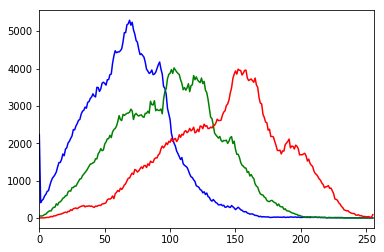

In [52]:
query_img = cv2.imread('./QUERY/00005.jpg')
color = ('b','g','r')
hist_query = np.empty([0, 256*3])
for i,col in enumerate(color):
    histr = cv2.calcHist([query_img],[i],None,[256],[0,256])
    histr_plt = histr
    histr = histr.transpose()
    if i == 0:
        hist_query = histr
    else:
        hist_query = np.concatenate((hist_query,histr), axis = 1)
    
    plt.plot(histr_plt,color = col)
    plt.xlim([0,256])
plt.show()

In [26]:
print(hist_query.shape)

(1, 768)


In [28]:
print(len(histogram_matrix))

279


In [34]:
A = np.array([])
print(A)

[]


# TASK 2 - Similarity measures

In [54]:
from scipy.spatial import distance

dist = 9999999
idx = 0
for i in range(0, len(histogram_matrix)):
    dst = distance.euclidean(hist_query, histogram_matrix[i,:])
    if dst < dist:
        dist = dst
        idx = i

print(idx)

80
